# BUSINESS PROBLEM

## Context

When a person applies for a loan, there are two types of decisions that could be taken by the company:

- Loan accepted: If the company approves the loan, there are 3 possible scenarios described below:

    -  Fully paid: Applicant has fully paid the loan (the principal and the interest rate)

    - Current: Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed. These candidates are not labelled as 'defaulted'.

    - Charged-off: Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has defaulted on the loan 

- Loan rejected: The company had rejected the loan (because the candidate does not meet their requirements etc.). Since the loan was rejected, there is no transactional history of those applicants with the company and so this data is not available with the company (and thus in this dataset)
![loan_image](./img/Loan_image.png)

## Business Objectives

The company wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default.  The company can utilise this knowledge for its portfolio and risk assessment. 

In [68]:
# Standard Python libs
import warnings
import typing
from datetime import datetime

# Data science libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored


# Use the warnings filter context manager to ignore specific warnings
with warnings.catch_warnings():
    # Filter out Pandas warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

# Data Understanding

- Objective variable: loan_status

## Load dataset as DataFrame to view data

In [69]:
df = pd.read_csv("loan.csv")
df.head(10)

/Users/geotech/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3526: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
5,1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
6,1069639,1304742,7000,7000,7000.0,60 months,15.96%,170.08,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
7,1072053,1288686,3000,3000,3000.0,36 months,18.64%,109.43,E,E1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
8,1071795,1306957,5600,5600,5600.0,60 months,21.28%,152.39,F,F2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
9,1071570,1306721,5375,5375,5350.0,60 months,12.69%,121.45,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


## Profiling Whole Dataframe to indentify data quality issue
![data_overview](./img/data_overview.png)


### Interpreted The Meaning of Fields

- Dataset contains the complete loan data for all loans issued through the time period 2007 t0 2011 (given in module introduction).
- There are 39717 rows and 111 columns
- There are 54 columns with highest missing values 39717. I think we should remove these after looking into it carefully. Some of them might be ouput columns where we need to find the values.
- Also few columns are there with many missing values. Some columns contain 1k, 2.4k, 12.9k, 25k, 37k, 38k missing values in it.

# Data Cleaning and Manipulation

## Address Data Quality Issue

### Data quality checklist
- Fix columns
    - Add columns name of missing
    - Rename columns consistently
    - Delete unnessesary columns
    - Split columns for more data
    - Merge columns for identifier
    - Align missalign columns

- Fix rows
    - Delete incorrect rows
    - Delete summary rows
    - Delete extra rows

- Fix missing values
    - Set values as missing (treat blank strings, "NA", "XX", "999", etc. as missing.)
    - Fill missing values with 
        - Constant (e.g zero)
        - Default values
        - Statistic value (e.g mode, mean, median, mix, max,....)
        - External data
    - Fill partial missing values using business judgement

- Filter data
    - Deduplicate Data by unique fields
    - Filter rows by segments, date periods
    - Filter columns pick relevant columns to analysis
    - Aggregate data

- Stadardize data
    - Remove extra characters
    - Standardize case (e.g UPPERCASE or lowercase)
    - Standardize format


### Measure and remove columns contain 100% missing value

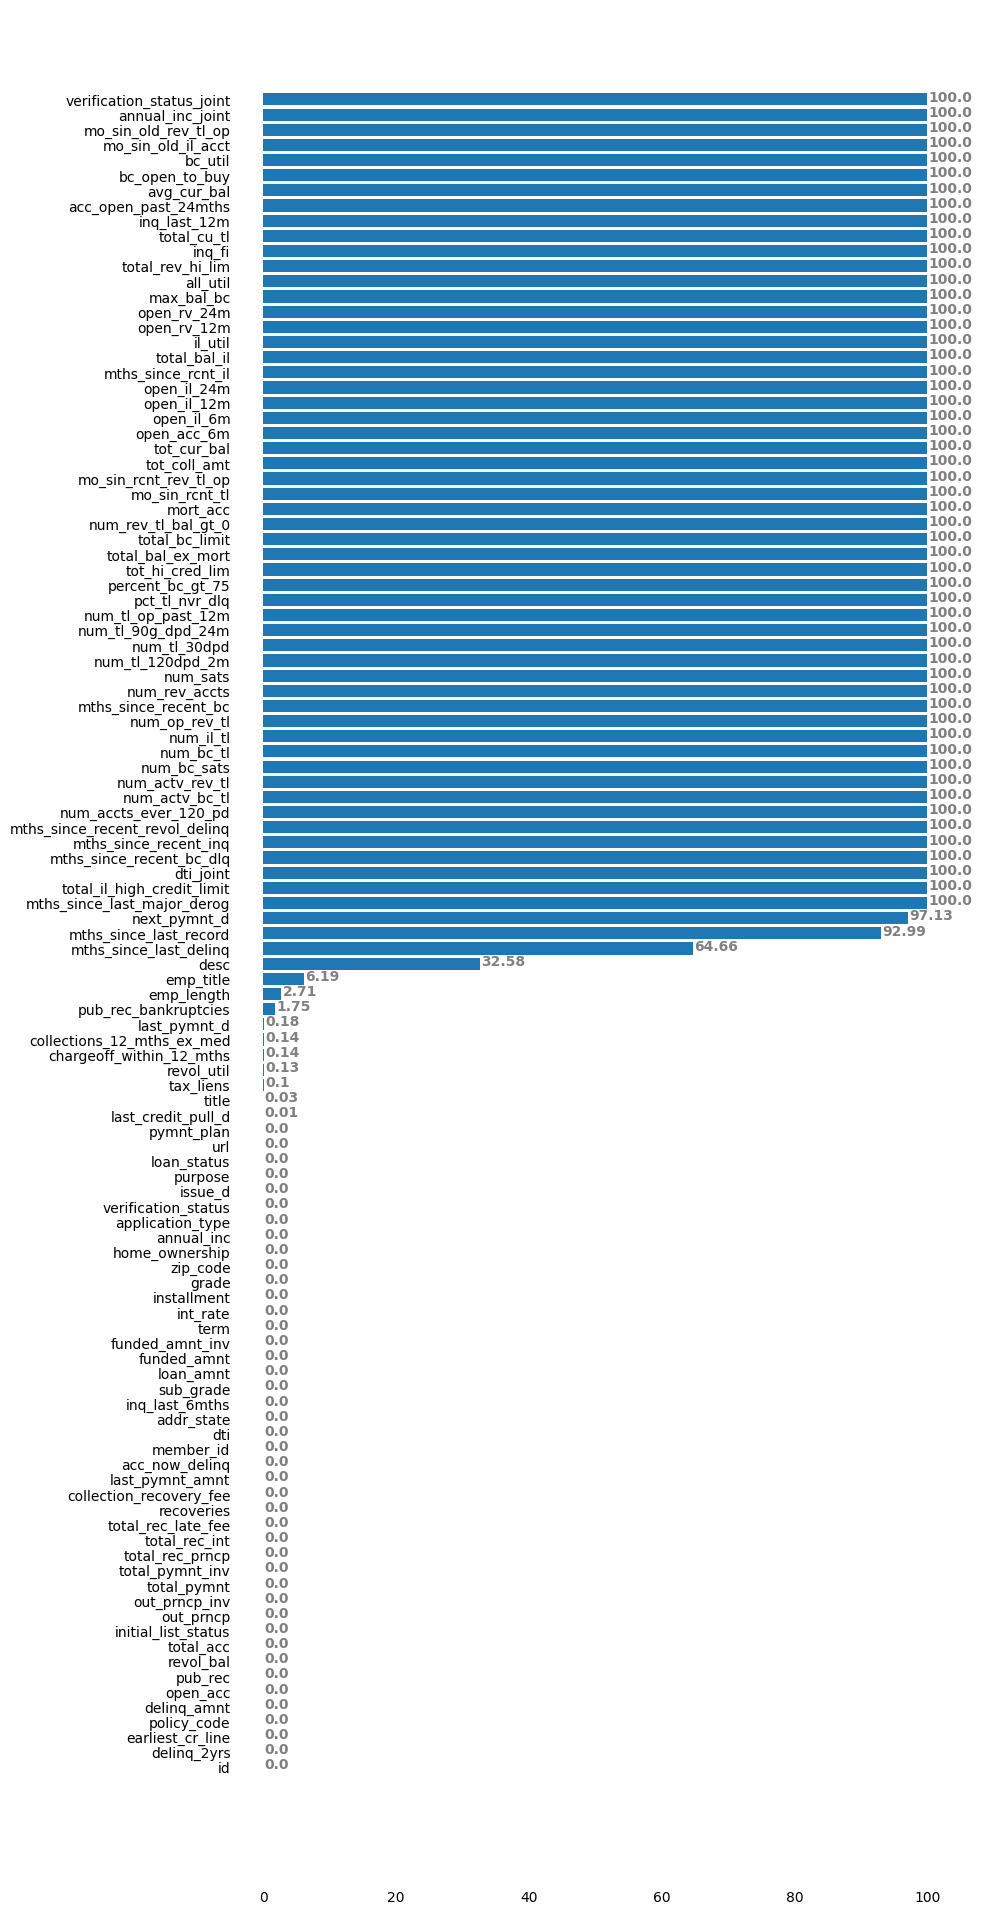

In [70]:
# We measure percentage missing value in per field and introduce a new dataframe to monitor
missing_df = df.isnull().sum() * 100 / len(df)
missing_df.to_frame(name="percent_missing")

missing_df = missing_df.reset_index()
missing_df.columns = ['field', 'percent_missing']
missing_df = missing_df.sort_values(by="percent_missing", ascending=False)

# Figure Size
fig, ax = plt.subplots(figsize =(9, 24))
 
# Horizontal Bar Plot
ax.barh(missing_df["field"], missing_df["percent_missing"])

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 20)
ax.yaxis.set_tick_params(pad = 20)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 

plt.show()

In [71]:
# We wil remove all field missing value is 100%
df = df.drop(columns=missing_df[missing_df["percent_missing"] == 100]["field"].to_list())
df.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,Sep-13,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,Apr-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,Jun-16,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
5,1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,...,NaN,Jan-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
6,1069639,1304742,7000,7000,7000.0,60 months,15.96%,170.08,C,C5,...,NaN,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
7,1072053,1288686,3000,3000,3000.0,36 months,18.64%,109.43,E,E1,...,NaN,Dec-14,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
8,1071795,1306957,5600,5600,5600.0,60 months,21.28%,152.39,F,F2,...,NaN,Aug-12,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
9,1071570,1306721,5375,5375,5350.0,60 months,12.69%,121.45,B,B5,...,NaN,Mar-13,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0


### There are the rest of 15 missing fields

| field                      | percent missing | describe                                                                                                                          | fill missing solution |
| -------------------------- | --------------- | --------------------------------------------------------------------------------------------------------------------------------- | --------------------- |
| next_pymnt_d               | 97%             | Next scheduled payment date                                                                                                       | Ignore                   |
| mths_since_last_record     | 93%             | The number of months since the last public Ignore.                                                                                | Drop                   |
| mths_since_last_delinq     | 67%             | Loan description provided by the borrower                                                                                         | Ignore                   |
| desc                       | 33%             | Loan description provided by the borrower                                                                                         | Ignore                   |
| emp_title                  | 6%              | The job title supplied by the Borrower when applying for the loan.\*                                                              | Ignore                   |
| emp_length                 | 3%              | Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. |    Ignore                 |
| pub_rec_bankruptcies       | 2%              | Number of public record bankruptcies                                                                                              | Ignore                   |
| last_pymnt_d               | 0.1%            | Last month payment was received                                                                                                   | Ignore                   |
| chargeoff_within_12_mths   | 0.1%            | Number of charge-offs within 12 months                                                                                            | Ignore                   |
| collections_12_mths_ex_med | 0.1%            | Number of collections in 12 months excluding medical collections                                                                  | Ignore                   |
| revol_util                 | 0.1%            | Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.        | Ignore                   |
| tax_liens                  | 0.1%            | Number of tax liens                                                                                                               | Fill NA by O          |
| title                      | 0.1%            | The loan title provided by the borrower                                                                                           | Drop                   |
| last_credit_pull_d         | 0.1%            | The most recent month LC pulled credit for this loan                                                                              | Ignore                   |






In [72]:
# Handle missing value for 15 fields
# We will review column by column to understand business logic behind that field to 
# chose the suitable fillna soluton

# We will fill all missing value in field "tax_liens" with 0
df["tax_liens"] = df["tax_liens"].fillna(0)

# We will drop the field 
try:
    df = df.drop(columns=["emp_title", "title", "emp_length", "desc", "earliest_cr_line"])
except KeyError:
    pass

# We will ignore null values in the fields:
# - pub_rec_bankruptcies
# - last_pymnt_d

len(df.columns)

52

### Address Constant Field
Constant fields are fieds contain only one value. In our problem we want to find out features which impact to the behavior of borrower so field with one value have no meaning

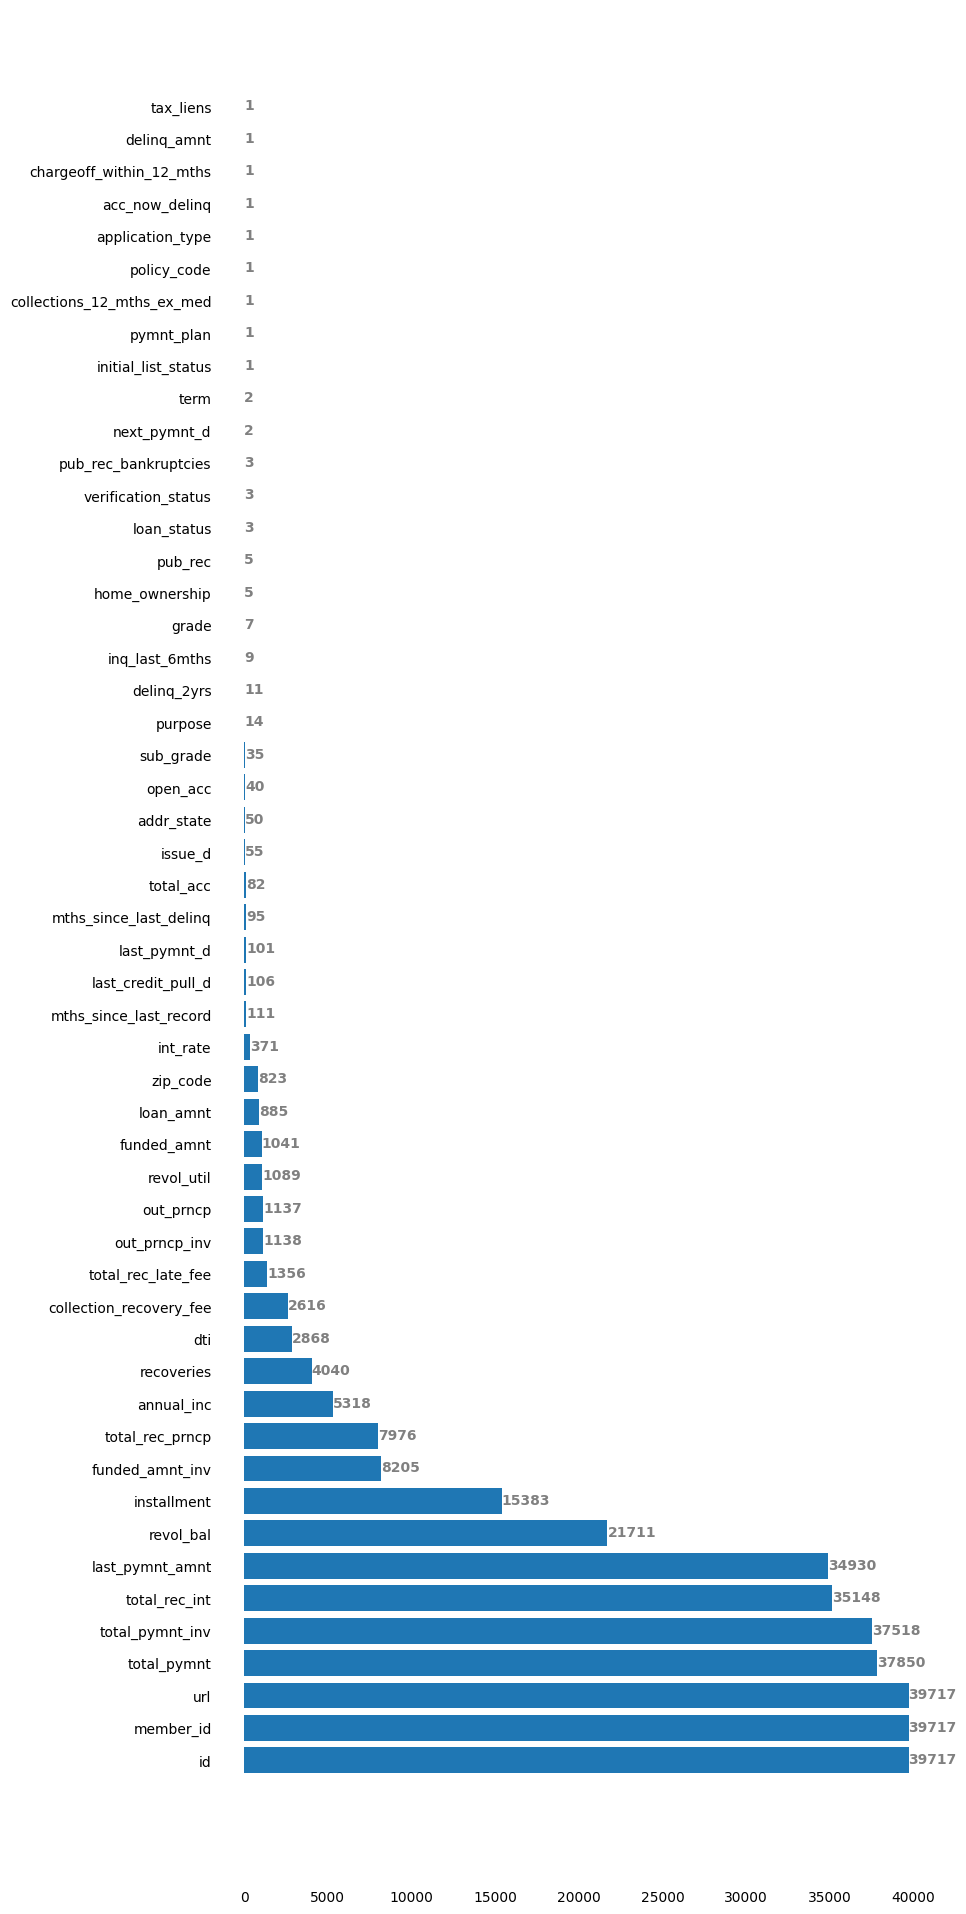

In [73]:
constant_df = df.nunique().to_frame(name='unique_value')
constant_df = constant_df.reset_index()
constant_df = constant_df.rename(columns={'index': 'field'}).sort_values(by='unique_value', ascending=True)

# Figure Size
fig, ax = plt.subplots(figsize =(9, 24))
 
# Horizontal Bar Plot
ax.barh(constant_df["field"], constant_df["unique_value"])

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 20)
ax.yaxis.set_tick_params(pad = 20)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 

plt.show()

In [74]:
# Drop Constant Field Because No Statistic Meaning
try:
    df = df.drop(columns=constant_df[constant_df["unique_value"] == 1]["field"].to_list())
except KeyError:
    pass

print(len(df.columns))
df.head(10)

43


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,Jun-16,May-16,0.0
5,1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,...,5000.00,632.21,0.00,0.00,0.00,Jan-15,161.03,NaN,Jan-16,0.0
6,1069639,1304742,7000,7000,7000.0,60 months,15.96%,170.08,C,C5,...,6985.61,3125.23,0.00,0.00,0.00,May-16,1313.76,NaN,May-16,0.0
7,1072053,1288686,3000,3000,3000.0,36 months,18.64%,109.43,E,E1,...,3000.00,939.14,0.00,0.00,0.00,Jan-15,111.34,NaN,Dec-14,0.0
8,1071795,1306957,5600,5600,5600.0,60 months,21.28%,152.39,F,F2,...,162.02,294.94,0.00,189.06,2.09,Apr-12,152.39,NaN,Aug-12,0.0
9,1071570,1306721,5375,5375,5350.0,60 months,12.69%,121.45,B,B5,...,673.48,533.42,0.00,269.29,2.52,Nov-12,121.45,NaN,Mar-13,0.0


### Address Unique Field
Unique fields are fields have 100% unique value

In [75]:
unique_df = df.nunique() == len(df)
unique_df = unique_df.to_frame(name='is_unique_field')
unique_df = unique_df.reset_index()
unique_df = unique_df.rename(columns={'index': 'field'}).sort_values(by='is_unique_field', ascending=False)
unique_df[unique_df["is_unique_field"] == True].head()

,field,is_unique_field
0,id,True
15,url,True
1,member_id,True


In [76]:
# Drop Uniue Field To Avoid Mistake in Segmentation
try:
    df = df.drop(columns=unique_df[unique_df["is_unique_field"] == True]["field"].to_list())
except KeyError:
    pass

### Convert Data Type

We will create a expected datatype for each field and check with current datatype aim to detect wrong datatype fields

In [77]:
def load_type_df(df: pd.DataFrame, filter_type: str = None) -> pd.DataFrame:
    default_type_df = df.dtypes.to_frame(name='default_type')
    default_type_df = default_type_df.reset_index()

    if filter_type:
        default_type_df = default_type_df[default_type_df['default_type'] == filter_type]

    return default_type_df.rename(columns={'index': 'field'})


def assert_datatypes(df: pd.DataFrame) -> pd.DataFrame:

    default_type_df = load_type_df(df)

    # types_df

    expected_type_df = pd.read_csv("expected_datatype.csv")
    types_df = pd.merge(default_type_df, expected_type_df, how='left', on='field')
    return types_df[types_df['default_type'] != types_df['expected_type']]


assert_datatypes(df)

,field,default_type,expected_type
4,int_rate,object,float64
11,issue_d,object,datetime64[ns]
24,revol_util,object,float64
35,last_pymnt_d,object,datetime64[ns]
37,next_pymnt_d,object,datetime64[ns]
38,last_credit_pull_d,object,datetime64[ns]


In [79]:
def convert_2_percentage(x: typing.Any) -> float:        
    if isinstance(x, str):
        return float(x.replace("%", ""))
    return x
    
def convert_to_month(x: typing.Any) -> datetime:
    if isinstance(x, str):
        return datetime.strptime(x, "%b-%y")
    return x

def standardize_free_text(x: str) -> str:
    return str(x).replace(' ', '_').lower()
    


# Standardize percentage fields
df["revol_util"] = df['revol_util'].apply(convert_2_percentage)
df["int_rate"] = df['int_rate'].apply(convert_2_percentage)

# Standardize date fields
df["issue_d"] = df["issue_d"].apply(convert_to_month)
df["last_pymnt_d"] = df["last_pymnt_d"].apply(convert_to_month)
df["last_credit_pull_d"] = df["last_credit_pull_d"].apply(convert_to_month)
df["next_pymnt_d"] = df["next_pymnt_d"].apply(convert_to_month)

# Standardize free text field
df['purpose'] = df['purpose'].apply(standardize_free_text)


# Make sure all field cast to expeted datatype
assert len(assert_datatypes(df)) == 0

## Data Analysis

### Analysis Objective
Find out the high-impact factors which can lead to a default transaction


### Data Analysis Strategy
We will filter all the hidden relationship between field "is_default" with other fields by <strong>SEGMENTED UNVARIATE ANALYSIS</strong> to find out high-impact fields.

After that we wil deep-dive to each field in the high-impact group by <strong>UNIVARIATE ANALYSIS</strong> and figure out the correlation between them by <strong>BIVARIATE ANALYSIS</strong>

### Data Analysis Methodology
- Univariate analysis
    - Unordered categorical variable -> Frequency and ranking -> Scatter plot
    - Ordered categorical variable -> Sort, frequency -> Histogram to see distribution
    - Quantitative variable -> 
        - Descriptive Data Summary
            - Statistic metrics: Q1/2/3, Mean, Median, Mod, Max, Min, Variant, SD
            - Boxplot
- Segmented univariate analysis
    - Group by dimesion 
    - Summarize relevant metrics by mean, median
    - Compare aggregated metrics 
- Bivariate analysis
    - On continuous variables
        - Scatter plot
        - Correlation heatmap metrix
    - On categorical variables
        - Pivot table
- Derived metrics
    - Type-driven metrics
        - Nominal variables
        - Ordinal variables
        - Interval variables
        - Ratio variables
    - Business-driven metrics
    - Data-driven



In [81]:
# Mark is default case
df["is_default"] = df["loan_status"].apply(lambda x: 'YES' if x.lower() == 'charged off' else 'NO')

### Bivariate Analysis Between Datetime Field with Target Variable "is_default"

issue_d     is_default
2007-08-01  7             1
2009-11-01  83            1
2010-01-01  76            1
2010-02-01  63            1
2010-03-01  69            1
2010-04-01  82            1
2010-05-01  125           1
2010-06-01  166           1
2010-07-01  137           1
2010-08-01  148           1
2010-09-01  175           1
2010-10-01  160           1
2010-11-01  142           1
2010-12-01  142           1
2011-01-01  186           1
2011-02-01  168           1
2011-03-01  207           1
2011-04-01  221           1
2011-05-01  289           1
2011-06-01  267           1
2011-07-01  278           1
2011-08-01  267           1
2011-09-01  307           1
2011-10-01  308           1
2011-11-01  335           1
2009-12-01  62            1
2009-10-01  87            1
2007-09-01  3             1
2009-09-01  57            1
2007-10-01  10            1
2007-11-01  7             1
2007-12-01  18            1
2008-01-01  31            1
2008-02-01  25            1
2008-03-01  40           

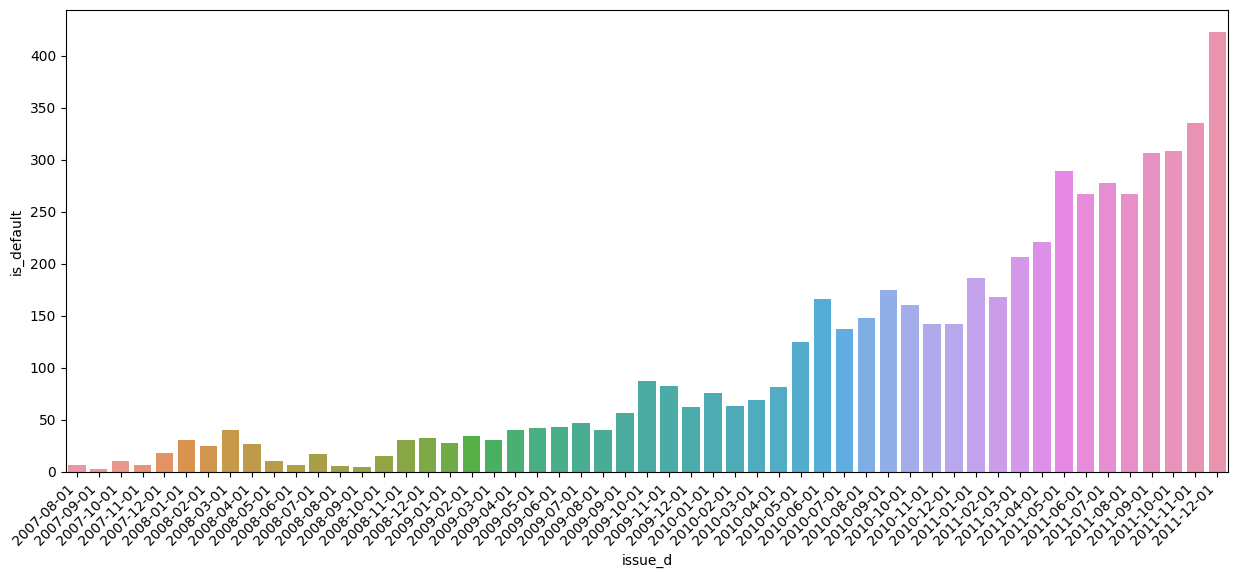

last_pymnt_d  is_default
2008-03-01    1             1
2012-05-01    129           1
2014-03-01    55            1
2014-02-01    66            1
2014-01-01    76            1
                           ..
2010-10-01    58            1
2010-09-01    50            1
2010-08-01    43            1
2010-07-01    51            1
2016-04-01    2             1
Length: 97, dtype: int64


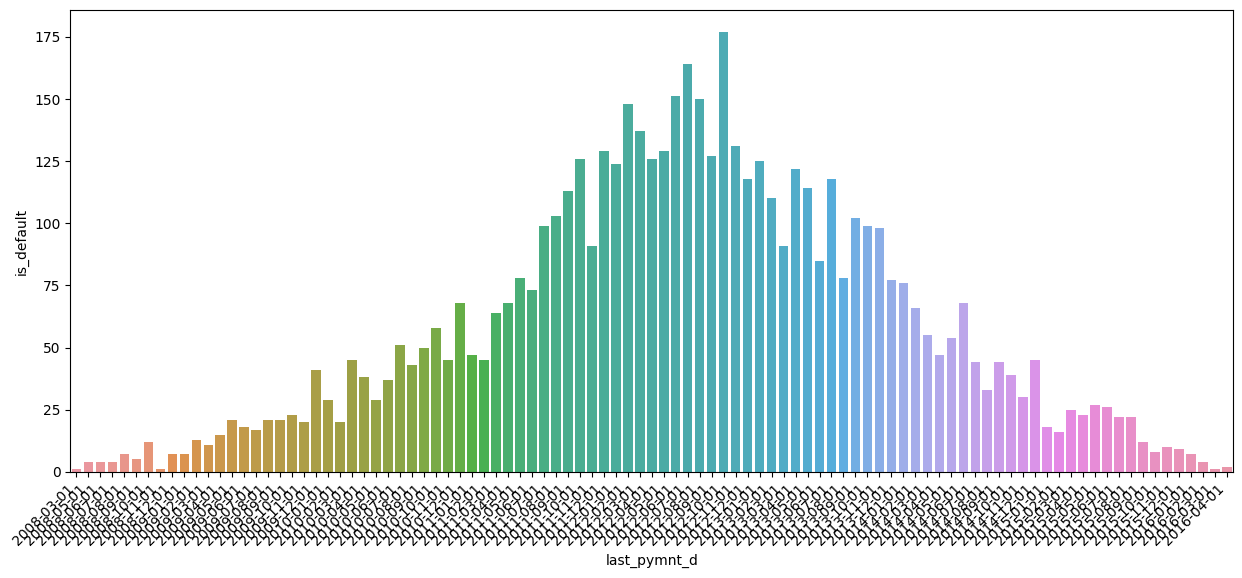

Series([], dtype: int64)
last_credit_pull_d  is_default
2009-01-01          6             1
2014-09-01          41            1
2014-07-01          45            1
2014-06-01          54            1
2014-05-01          59            1
                                 ..
2011-08-01          47            1
2011-07-01          27            1
2011-06-01          26            1
2011-05-01          28            1
2016-05-01          1991          1
Length: 83, dtype: int64


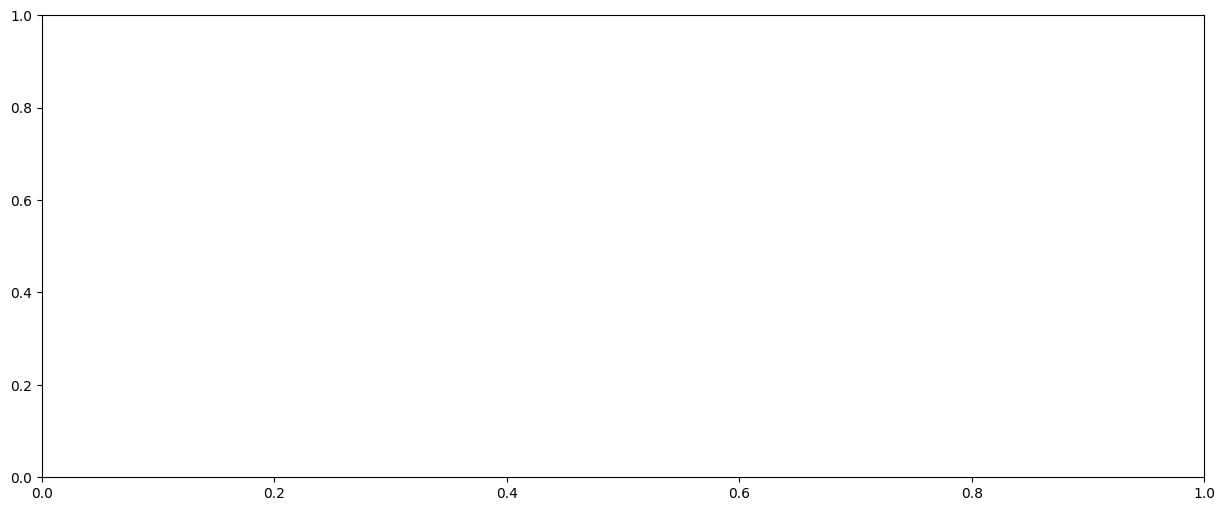

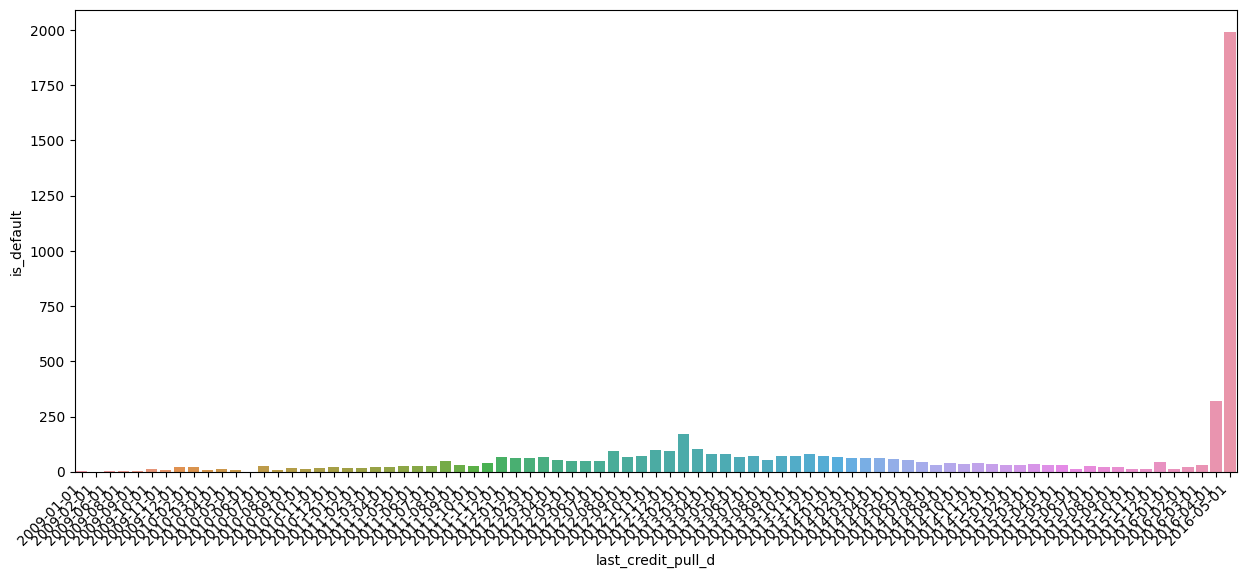

In [83]:

field_df = pd.concat([load_type_df(df, 'datetime64[ns]')])

for field in field_df["field"].to_list():

    try:

        agg_df = df[df["is_default"] == "YES"][["is_default", field]].groupby(field).agg({"is_default": "count"})
        agg_df = agg_df.reset_index()

        print(agg_df.value_counts())

        fig, ax = plt.subplots(figsize=(15,6))

        sns.barplot(agg_df, x=field, y="is_default", ax=ax)

        x_dates = agg_df[field].dt.strftime('%Y-%m-%d').sort_values().unique()
        ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
        plt.show()
    except:
        pass

### SEGMENTED ANALYSIS Between "is_default" variable and all numeric variable

============ Stats On Field loan_amnt ================
count    38487.000000
mean     10521.750201
std       6441.089924
min        500.000000
25%       5125.000000
50%       9600.000000
75%      15000.000000
max      29175.000000
Name: loan_amnt, dtype: float64


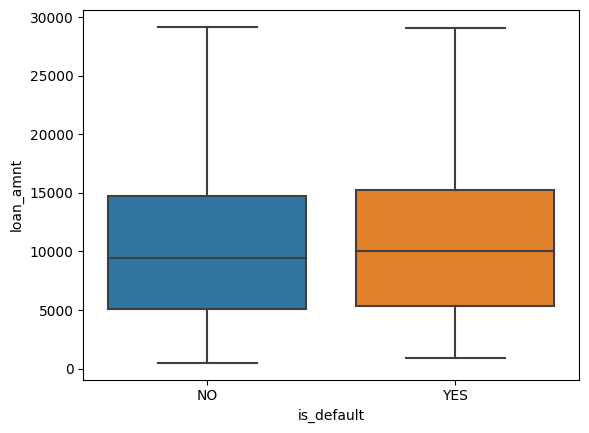

============ Stats On Field funded_amnt ================
count    38679.000000
mean     10356.773701
std       6287.614659
min        500.000000
25%       5050.000000
50%       9350.000000
75%      14500.000000
max      29375.000000
Name: funded_amnt, dtype: float64


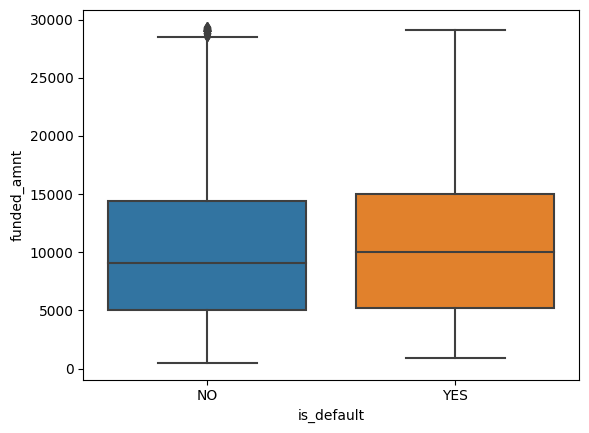

============ Stats On Field inq_last_6mths ================
count    36083.000000
mean         0.626195
std          0.745813
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: inq_last_6mths, dtype: float64


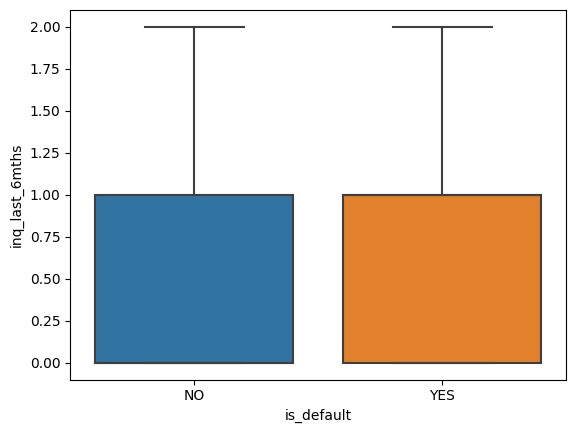

============ Stats On Field open_acc ================
count    38958.000000
mean         9.017172
std          3.938914
min          2.000000
25%          6.000000
50%          8.000000
75%         12.000000
max         20.000000
Name: open_acc, dtype: float64


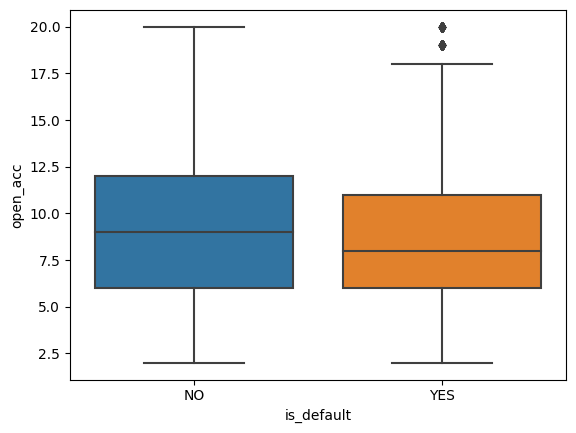

============ Stats On Field revol_bal ================
count    37220.000000
mean     10227.422864
std       8522.492254
min          0.000000
25%       3409.750000
50%       8123.000000
75%      14981.000000
max      37086.000000
Name: revol_bal, dtype: float64


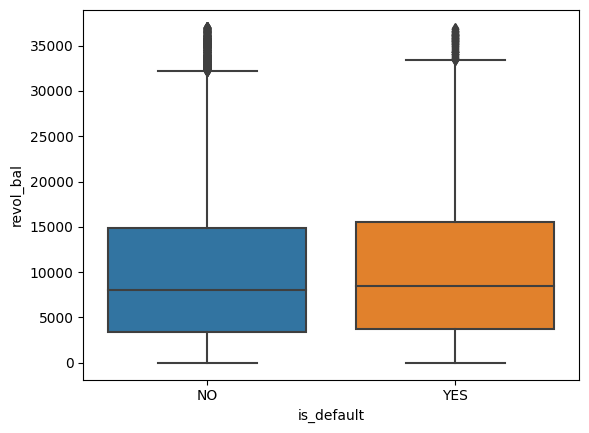

============ Stats On Field total_acc ================
count    39106.000000
mean        21.519971
std         10.516916
min          2.000000
25%         13.000000
50%         20.000000
75%         28.000000
max         52.000000
Name: total_acc, dtype: float64


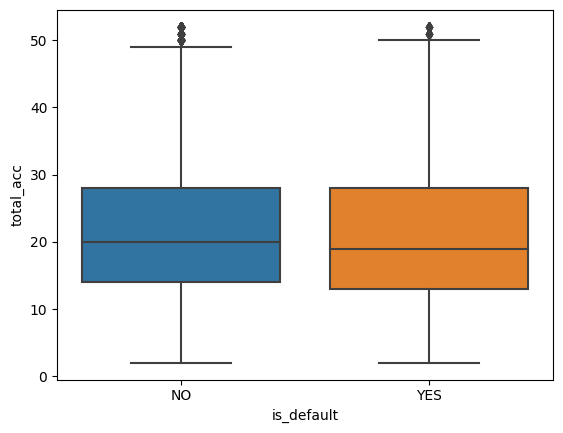

============ Stats On Field funded_amnt_inv ================
count    38716.000000
mean      9823.048791
std       6236.182595
min          0.000000
25%       5000.000000
50%       8516.530296
75%      13900.000000
max      28478.507380
Name: funded_amnt_inv, dtype: float64


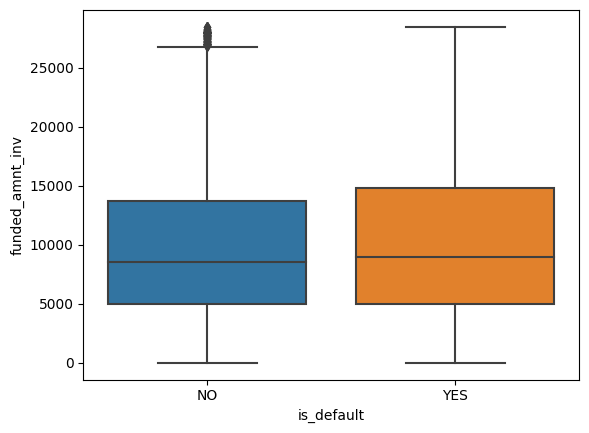

============ Stats On Field int_rate ================
count    39639.000000
mean        11.999077
std          3.694926
min          5.420000
25%          9.250000
50%         11.830000
75%         14.540000
max         22.480000
Name: int_rate, dtype: float64


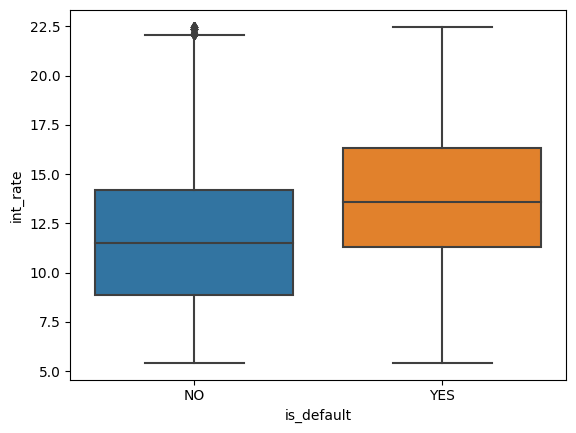

============ Stats On Field installment ================
count    38472.000000
mean       304.899376
std        179.729329
min         15.690000
25%        164.110000
50%        272.960000
75%        407.102500
max        826.310000
Name: installment, dtype: float64


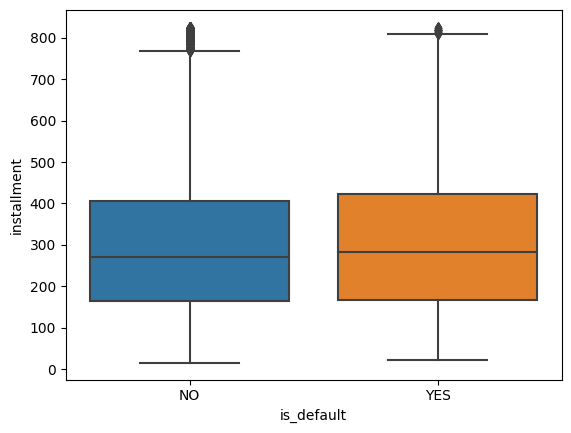

============ Stats On Field annual_inc ================
count     37874.000000
mean      61360.038960
std       28210.186388
min        4000.000000
25%       40000.000000
50%       56178.000000
75%       78000.000000
max      145008.000000
Name: annual_inc, dtype: float64


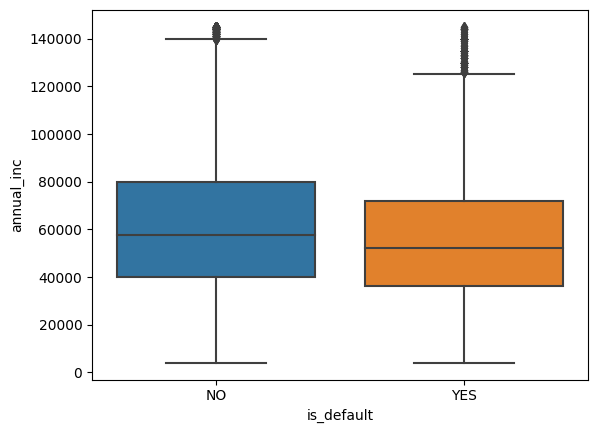

============ Stats On Field dti ================
count    39717.000000
mean        13.315130
std          6.678594
min          0.000000
25%          8.170000
50%         13.400000
75%         18.600000
max         29.990000
Name: dti, dtype: float64


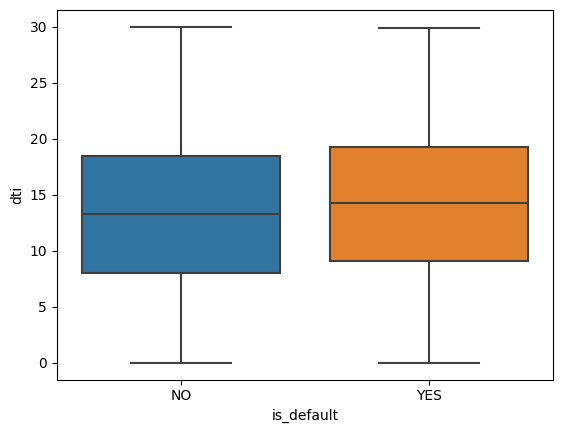

============ Stats On Field total_pymnt ================
count    38383.000000
mean     11188.869150
std       7473.048173
min          0.000000
25%       5478.520710
50%       9517.071340
75%      15590.091255
max      32965.350000
Name: total_pymnt, dtype: float64


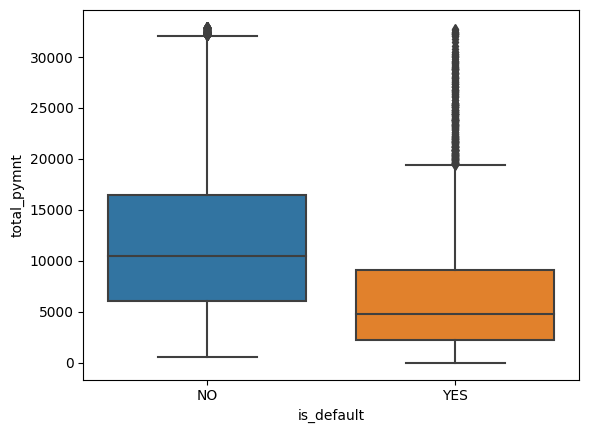

============ Stats On Field total_pymnt_inv ================
count    38276.000000
mean     10549.371427
std       7301.565983
min          0.000000
25%       4966.847500
50%       8910.405000
75%      14816.572500
max      31827.920000
Name: total_pymnt_inv, dtype: float64


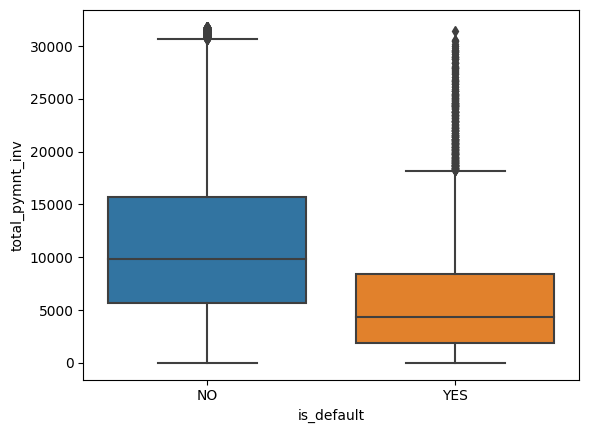

============ Stats On Field total_rec_prncp ================
count    38745.000000
mean      9240.370957
std       6203.394713
min          0.000000
25%       4500.000000
50%       8000.000000
75%      12850.000000
max      27175.000000
Name: total_rec_prncp, dtype: float64


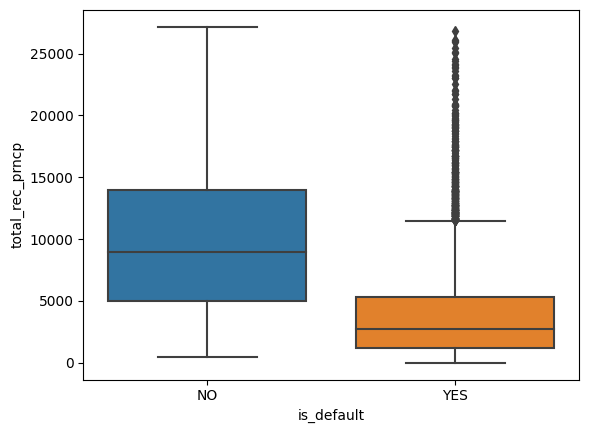

============ Stats On Field total_rec_int ================
count    36560.000000
mean      1656.898978
std       1383.254500
min          0.000000
25%        614.135000
50%       1211.950000
75%       2332.680000
max       6089.280000
Name: total_rec_int, dtype: float64


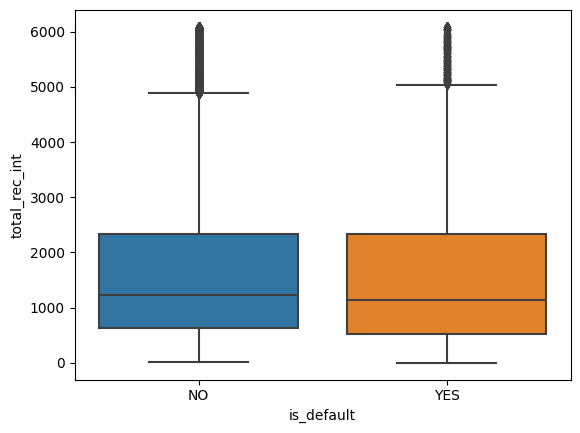

============ Stats On Field last_pymnt_amnt ================
count    35431.000000
mean      1388.031765
std       1888.514431
min          0.000000
25%        196.860000
50%        438.070000
75%       1902.720000
max       7903.070000
Name: last_pymnt_amnt, dtype: float64


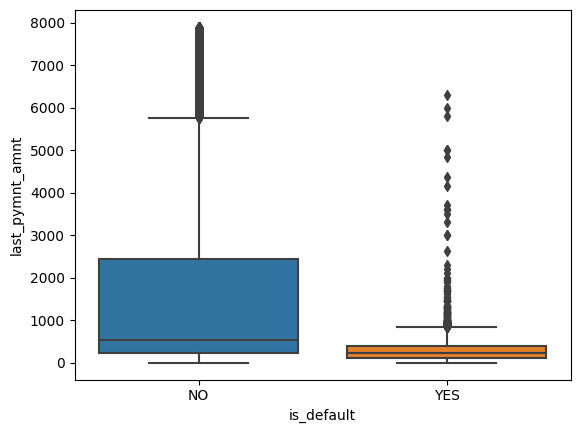

In [ ]:
# Analysis on total_acc
def remove_outliers(df: pd.DataFrame, field: str) -> pd.DataFrame:
    """
        Function remove all outlier from a dataframe
        by identifying the upper bound and lower bound
    """
    Q1 = np.percentile(df[field], 25, method='midpoint')
    Q3 = np.percentile(df[field], 75, method='midpoint')
    IQR = Q3 - Q1
    upper=Q3+1.5*IQR
    lower=Q1-1.5*IQR
    
    return df[(df[field] < upper) & (df[field] > lower)].dropna()


field_df = pd.concat([load_type_df(df, 'int64'), load_type_df(df, 'float64')])
for field in field_df["field"].to_list():

    clean_df: pd.DataFrame = remove_outliers(df[[field, "is_default"]], field)

    if clean_df.empty:
        continue

    sns.boxplot(y=field, x="is_default", data=clean_df)
    print(f"============ Stats On Field {field} ================")
    print(clean_df[field].describe())
    plt.show()

### BIVARIATE ANALYSIS Between "is_default" variable and all categorical variables

In [ ]:
print(load_type_df(df, 'object'))

                  field default_type
3                  term       object
6                 grade       object
7             sub_grade       object
8             emp_title       object
9            emp_length       object
10       home_ownership       object
12  verification_status       object
14          loan_status       object
15                 desc       object
16              purpose       object
17                title       object
18             zip_code       object
19           addr_state       object
45           is_default       object


In [ ]:
df.shape

(39717, 57)

In [ ]:

cm = sns.color_palette("blend:white,green", as_cmap=True)

t = pd.pivot_table(
    df, 
    index='grade', 
    columns='is_default', 
    values='loan_amnt', 
    aggfunc='count',
    ).apply(lambda x: round(x*100/sum(x), 2))

t.style.background_gradient(cm)

is_default,NO,YES
grade,,
A,27.820000,10.700000
B,31.080000,25.320000
C,19.800000,23.940000
D,12.290000,19.870000
E,6.240000,12.710000
F,2.140000,5.670000
G,0.630000,1.790000


In [ ]:
t = pd.pivot_table(
    df, 
    index='sub_grade', 
    columns='is_default', 
    values='loan_amnt', 
    aggfunc='count',
    fill_value=0,
    margins=True
    ).sort_index()


t.div(t.iloc[:,-1], axis=0 )

t.style.background_gradient(cm)

is_default,NO,YES,All
sub_grade,,,
A1,1109,30,1139
A2,1434,74,1508
A3,1707,103,1810
A4,2708,178,2886
A5,2525,217,2742
All,34090,5627,39717
B1,1659,171,1830
B2,1829,228,2057
B3,2576,341,2917


In [ ]:
# pd.pivot_table(df, index='term', columns='is_default', values='loan_amnt', aggfunc='count').style.background_gradient(cm)

t = pd.pivot_table(
    df, 
    index='term', 
    columns='is_default', 
    values='loan_amnt', 
    aggfunc='count',
    margins=True
    )
t.div(t.iloc[:,-1], axis=0 ).mul(100).style.background_gradient(cm)


is_default,NO,YES,All
term,,,
36 months,88.909128,11.090872,100.000000
60 months,77.403258,22.596742,100.000000
All,85.832263,14.167737,100.000000


In [ ]:
# pd.pivot_table(df, index='purpose', columns='is_default', values='loan_amnt', aggfunc='count').style.background_gradient(cm)

t = pd.pivot_table(
    df, 
    index='purpose', 
    columns='is_default', 
    values='loan_amnt', 
    aggfunc='count',
    margins=True
    )
t.div(t.iloc[:,-1], axis=0 ).mul(100).style.background_gradient(cm)

is_default,NO,YES,All
purpose,,,
car,89.670755,10.329245,100.000000
credit_card,89.434698,10.565302,100.000000
debt_consolidation,85.156376,14.843624,100.000000
educational,82.769231,17.230769,100.000000
home_improvement,88.340054,11.659946,100.000000
house,84.514436,15.485564,100.000000
major_purchase,89.849108,10.150892,100.000000
medical,84.704185,15.295815,100.000000
moving,84.219554,15.780446,100.000000


In [ ]:
t = pd.pivot_table(
    df, 
    index='verification_status', 
    columns='is_default', 
    values='loan_amnt', 
    aggfunc='count',
    margins=True
    )
t.div(t.iloc[:,-1], axis=0 ).mul(100).style.background_gradient(cm)

is_default,NO,YES,All
verification_status,,,
Not Verified,87.341174,12.658826,100.000000
Source Verified,85.641334,14.358666,100.000000
Verified,83.987821,16.012179,100.000000
All,85.832263,14.167737,100.000000


In [ ]:
t = pd.pivot_table(
    df, 
    index='home_ownership', 
    columns='is_default', 
    values='loan_amnt', 
    aggfunc='count',
    margins=True
    )
t.div(t.iloc[:,-1], axis=0 ).mul(100).style.background_gradient(cm)

is_default,NO,YES,All
home_ownership,,,
MORTGAGE,86.822583,13.177417,100.000000
NONE,100.000000,nan,100.000000
OTHER,81.632653,18.367347,100.000000
OWN,85.513407,14.486593,100.000000
RENT,84.978041,15.021959,100.000000
All,85.832263,14.167737,100.000000


### Norminal Variable 

(array([10085., 12020.,     0.,  8098.,     0.,  5307.,  2842.,     0.,
         1049.,   316.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

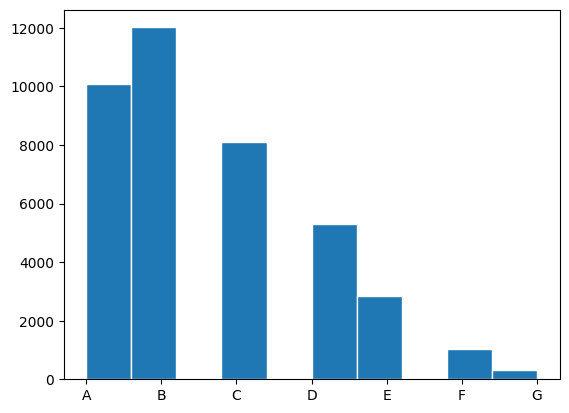

In [ ]:
# Get Unorder categorical variable
plt.hist(df["grade"].sort_values(), edgecolor='w')

(array([6615., 6353., 4539., 6568., 5169., 5578., 2339., 1466.,  760.,
         330.]),
 array([ 0. ,  3.4,  6.8, 10.2, 13.6, 17. , 20.4, 23.8, 27.2, 30.6, 34. ]),
 <BarContainer object of 10 artists>)

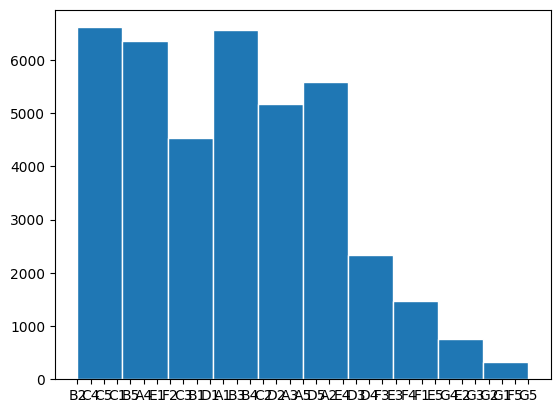

In [ ]:
plt.hist(df["sub_grade"].sort_index(), edgecolor='w')

### Deep Dive Into High-impact numeric variables
We found high-impact variables 
- last_pymnt_amnt
- total_rec_prncp
- total_pymnt_inv
- int_rate
- annual_inc

Because there are significant difference between Default and Un-default case. Then we analyse the correlation between them

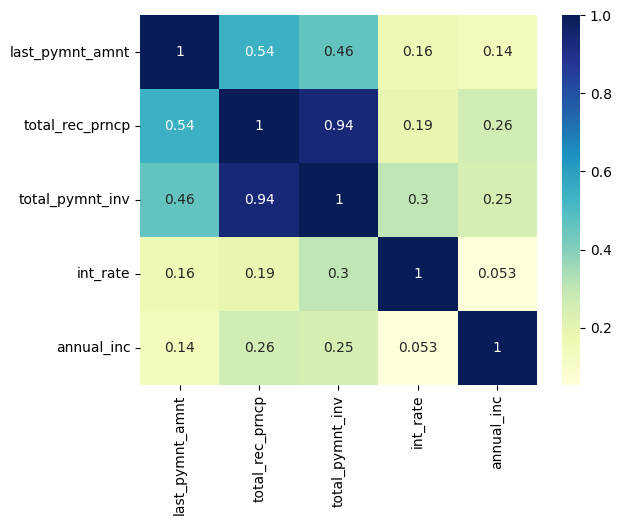

In [ ]:
dataplot = sns.heatmap(df[["last_pymnt_amnt", "total_rec_prncp", "total_pymnt_inv", "int_rate", "annual_inc"]].corr()
                      , cmap="YlGnBu", annot=True
                      )
plt.show()


## CONCLUSION
